In [1]:
import sys
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import phantom as ph

import cloudpickle

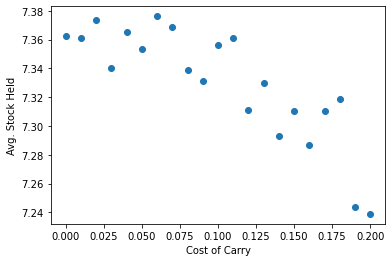

In [17]:
results = cloudpickle.load(open("../../../results1.pkl", "rb"))

data = defaultdict(list)

for result in results:
    data[result["cost_of_carry"]].append(result["mean_stock_held"])

x = list(data.keys())
y = list(map(np.mean, data.values()))

plt.scatter(x, y)
plt.xlabel("Cost of Carry")
plt.ylabel("Avg. Stock Held")
plt.show()

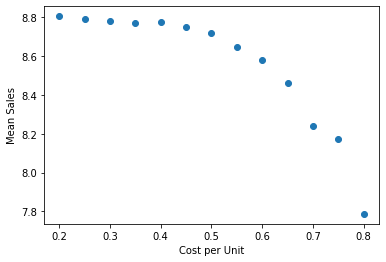

In [18]:
results = cloudpickle.load(open("../../../results2.pkl", "rb"))

data = defaultdict(list)

for result in results:
    data[result["cost_per_unit"]].append(result["mean_sales"])

x = list(data.keys())
y = list(map(np.mean, data.values()))

plt.scatter(x, y)
plt.xlabel("Cost per Unit")
plt.ylabel("Mean Sales")
plt.show()

In [20]:
results = cloudpickle.load(open("../../../results3.pkl", "rb"))

for metric in results[0].keys():
    print(metric, np.mean([m[metric] for m in results]))

stock/SHOP1 7.261340000000001
sales/SHOP1 8.7314
price/SHOP1 1.01
missed_sales/SHOP1 1.26654
delivered_stock/SHOP1 8.87852
